# Importing Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Model Hyperparameters

In [2]:
batch_size = 16
learning_rate = 0.0001
num_epochs = 50
image_size = 256
num_classes = 5

# Set Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# U-net Model Class

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )
    
    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = num_classes):
        super().__init__()

        #Encoding Layers
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 512)

        #Decoding Layers
        self.decoder1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv1 = DoubleConv(768, 256) # 512 + 256

        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv2 = DoubleConv(384, 128) # 256 + 128

        self.decoder3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv3 = DoubleConv(192, 64) # 128 + 64

        self.decoder4 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2)
        self.conv4 = DoubleConv(96, 32) # 64 + 32
        
        self.final = nn.Conv2d(32, out_channels, kernel_size = 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)

        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)

        bottleneck = self.bottleneck(pool4)

        dec1 = self.decoder1(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1) 
        dec1 = self.conv1(dec1)
        
        dec2 = self.decoder2(dec1)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.conv2(dec2)
        
        dec3 = self.decoder3(dec2)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.conv3(dec3)
        
        dec4 = self.decoder4(dec3)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.conv4(dec4)
        
        out = self.final(dec4)

        return out

# Dataset Class and Transforms

In [5]:
class CrackSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform = None, mask_transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.mask_transform = mask_transform

        all_files = os.listdir(data_dir)
        image_extensions = ('.jpg', '.jpeg', '.png')
        self.images = sorted([f for f in all_files if f.lower().endswith(image_extensions) and '_mask' not in f])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.data_dir, img_name)

        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_mask.png"
        mask_path = os.path.join(self.data_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        if self.transform:
            image = self.transform(image = image)['image']
        if self.mask_transform:
            mask = self.mask_transform(image = mask)['image']

        return image, mask.long()
    
# Transforms
train_tf = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])
val_tf = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(),
    ToTensorV2()
])
mask_tf = A.Compose([
    A.Resize(image_size, image_size),
    ToTensorV2()
])

# Datasets and DataLoaders

In [6]:
train_dataset= CrackSegmentationDataset('./data/train', transform = train_tf, mask_transform = mask_tf)
val_dataset = CrackSegmentationDataset('./data/valid', transform = val_tf, mask_transform = mask_tf)
test_dataset = CrackSegmentationDataset('./data/test', transform = val_tf, mask_transform = mask_tf)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, pin_memory = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, pin_memory = False)

# IoU Function

In [ ]:
def compute_iou(preds, labels, num_classes):
    all_ious = []
    for i in range(preds.shape[0]):
        pred = preds[i].view(-1)
        label = labels[i].view(-1)
        
        valid = (label >= 0) & (label < num_classes)
        pred = pred[valid]
        label = label[valid]

        ious = []

        for cls in range(num_classes):
            pred_mask = pred == cls
            label_mask = label == cls
            intersection = (pred_mask & label_mask).sum().item()
            union = pred_mask.sum().item() + label_mask.sum().item() - intersection
            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection / union)
        all_ious.append(ious)
    return np.nanmean(all_ious, axis=0)

# Dice Loss

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply softmax to model outputs to get probabilities
        inputs = torch.softmax(inputs, dim=1)
        
        # One-hot encode the target masks
        targets_one_hot = nn.functional.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2)
        
        # Calculate the Dice score for each class separately
        dice_per_class = []
        for i in range(self.num_classes):
            # Get the prediction and target for the current class
            input_class = inputs[:, i, :, :]
            target_class = targets_one_hot[:, i, :, :]
            
            # Flatten tensors
            input_flat = input_class.reshape(-1)
            target_flat = target_class.reshape(-1)
            
            # Calculate intersection and union
            intersection = (input_flat * target_flat).sum()
            union = input_flat.sum() + target_flat.sum()
            
            # Calculate Dice coefficient for the class
            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_per_class.append(dice_score)
        
        # Average the Dice scores across all classes
        # The loss is 1 minus the mean Dice coefficient
        return 1 - torch.mean(torch.stack(dice_per_class))

# Training and Validation Loops

In [9]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = DiceLoss(num_classes = num_classes)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Reduces LR when the quantity monitored has stopped decreasing
    factor=0.1,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5      # Number of epochs with no improvement after which learning rate will be reduced
)

best_miou = 0.0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc = f"Epoch {epoch + 1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        preds = model(images)

        loss = criterion(preds, masks.squeeze(1))

        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation Loop
    model.eval()

    val_loss = 0.0
    all_ious = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc = f"Epoch {epoch + 1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
                
            loss = criterion(preds, masks.squeeze(1))

            val_loss += loss.item()

            pred_labels = torch.argmax(preds, dim=1)
            ious = compute_iou(pred_labels.cpu(), masks.cpu(), num_classes)
            all_ious.append(compute_iou(pred_labels, masks.squeeze(1), num_classes))

        val_loss /= len(val_loader)
        
        mean_ious = np.nanmean(all_ious, axis=0)
        miou = np.nanmean(mean_ious)

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, mIoU = {miou:.4f}")

        scheduler.step(val_loss)

        if miou > best_miou:
            best_miou = miou
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "miou": best_miou
            }, "checkpoints/best_model.pth")
            print(f"Saved new best model with mIoU = {miou:.4f}")


Epoch 1/50: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Epoch 1: Train Loss = 0.8723, Val Loss = 0.8388, mIoU = 0.2316
Saved new best model with mIoU = 0.2316


Epoch 2/50: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Epoch 2: Train Loss = 0.8518, Val Loss = 0.8212, mIoU = 0.2189


Epoch 3/50: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Epoch 3: Train Loss = 0.8369, Val Loss = 0.8213, mIoU = 0.2048


Epoch 4/50: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 4: Train Loss = 0.8248, Val Loss = 0.8084, mIoU = 0.2139


Epoch 5/50: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Epoch 5: Train Loss = 0.8129, Val Loss = 0.7957, mIoU = 0.2184


Epoch 6/50: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch 6: Train Loss = 0.8034, Val Loss = 0.7823, mIoU = 0.2333
Saved new best model with mIoU = 0.2333


Epoch 7/50: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


Epoch 7: Train Loss = 0.7949, Val Loss = 0.7728, mIoU = 0.2192


Epoch 8/50: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 8: Train Loss = 0.7845, Val Loss = 0.7558, mIoU = 0.2316


Epoch 9/50: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Epoch 9: Train Loss = 0.7800, Val Loss = 0.7468, mIoU = 0.2358
Saved new best model with mIoU = 0.2358


Epoch 10/50: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Epoch 10: Train Loss = 0.7676, Val Loss = 0.7215, mIoU = 0.2506
Saved new best model with mIoU = 0.2506


Epoch 11/50: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Epoch 11: Train Loss = 0.7596, Val Loss = 0.6847, mIoU = 0.2635
Saved new best model with mIoU = 0.2635


Epoch 12/50: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Epoch 12: Train Loss = 0.7519, Val Loss = 0.6849, mIoU = 0.2576


Epoch 13/50: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Epoch 13: Train Loss = 0.7404, Val Loss = 0.6653, mIoU = 0.2550


Epoch 14/50: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Epoch 14: Train Loss = 0.7398, Val Loss = 0.6538, mIoU = 0.2691
Saved new best model with mIoU = 0.2691


Epoch 15/50: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 15: Train Loss = 0.7349, Val Loss = 0.6541, mIoU = 0.2576


Epoch 16/50: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 16: Train Loss = 0.7299, Val Loss = 0.6463, mIoU = 0.2590


Epoch 17/50: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch 17: Train Loss = 0.7218, Val Loss = 0.6234, mIoU = 0.2702
Saved new best model with mIoU = 0.2702


Epoch 18/50: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 18: Train Loss = 0.7186, Val Loss = 0.6095, mIoU = 0.2722
Saved new best model with mIoU = 0.2722


Epoch 19/50: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 19: Train Loss = 0.7173, Val Loss = 0.6049, mIoU = 0.2701


Epoch 20/50: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 20: Train Loss = 0.7199, Val Loss = 0.6041, mIoU = 0.2678


Epoch 21/50: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 21: Train Loss = 0.7096, Val Loss = 0.5716, mIoU = 0.2798
Saved new best model with mIoU = 0.2798


Epoch 22/50: 100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 22: Train Loss = 0.7091, Val Loss = 0.5666, mIoU = 0.2851
Saved new best model with mIoU = 0.2851


Epoch 23/50: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Epoch 23: Train Loss = 0.7052, Val Loss = 0.5853, mIoU = 0.2752


Epoch 24/50: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


Epoch 24: Train Loss = 0.7053, Val Loss = 0.5998, mIoU = 0.2713


Epoch 25/50: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Epoch 25: Train Loss = 0.7007, Val Loss = 0.5877, mIoU = 0.2760


Epoch 26/50: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 26: Train Loss = 0.7025, Val Loss = 0.5910, mIoU = 0.2716


Epoch 27/50: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Epoch 27: Train Loss = 0.6919, Val Loss = 0.5717, mIoU = 0.2773


Epoch 28/50: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Epoch 28: Train Loss = 0.6906, Val Loss = 0.6018, mIoU = 0.2601


Epoch 29/50: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Epoch 29: Train Loss = 0.6855, Val Loss = 0.5646, mIoU = 0.2803


Epoch 30/50: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Epoch 30: Train Loss = 0.6822, Val Loss = 0.5649, mIoU = 0.2802


Epoch 31/50: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch 31: Train Loss = 0.6815, Val Loss = 0.5604, mIoU = 0.2835


Epoch 32/50: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch 32: Train Loss = 0.6902, Val Loss = 0.5623, mIoU = 0.2822


Epoch 33/50: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


Epoch 33: Train Loss = 0.6818, Val Loss = 0.5535, mIoU = 0.2856
Saved new best model with mIoU = 0.2856


Epoch 34/50: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Epoch 34: Train Loss = 0.6842, Val Loss = 0.5564, mIoU = 0.2855


Epoch 35/50: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Epoch 35: Train Loss = 0.6844, Val Loss = 0.5573, mIoU = 0.2829


Epoch 36/50: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


Epoch 36: Train Loss = 0.6821, Val Loss = 0.5558, mIoU = 0.2851


Epoch 37/50: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


Epoch 37: Train Loss = 0.6811, Val Loss = 0.5525, mIoU = 0.2863
Saved new best model with mIoU = 0.2863


Epoch 38/50: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch 38: Train Loss = 0.6813, Val Loss = 0.5612, mIoU = 0.2817


Epoch 39/50: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 39: Train Loss = 0.6760, Val Loss = 0.5566, mIoU = 0.2853


Epoch 40/50: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Epoch 40: Train Loss = 0.6843, Val Loss = 0.5539, mIoU = 0.2862


Epoch 41/50: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 41: Train Loss = 0.6777, Val Loss = 0.5516, mIoU = 0.2874
Saved new best model with mIoU = 0.2874


Epoch 42/50: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


Epoch 42: Train Loss = 0.6699, Val Loss = 0.5540, mIoU = 0.2868


Epoch 43/50: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


Epoch 43: Train Loss = 0.6803, Val Loss = 0.5574, mIoU = 0.2852


Epoch 44/50: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Epoch 44: Train Loss = 0.6783, Val Loss = 0.5608, mIoU = 0.2847


Epoch 45/50: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch 45: Train Loss = 0.6812, Val Loss = 0.5609, mIoU = 0.2850


Epoch 46/50: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch 46: Train Loss = 0.6762, Val Loss = 0.5612, mIoU = 0.2848


Epoch 47/50: 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


Epoch 47: Train Loss = 0.6723, Val Loss = 0.5584, mIoU = 0.2863


Epoch 48/50: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch 48: Train Loss = 0.6739, Val Loss = 0.5594, mIoU = 0.2854


Epoch 49/50: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


Epoch 49: Train Loss = 0.6747, Val Loss = 0.5595, mIoU = 0.2860


Epoch 50/50: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]

Epoch 50: Train Loss = 0.6820, Val Loss = 0.5578, mIoU = 0.2863


# Visualizing Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

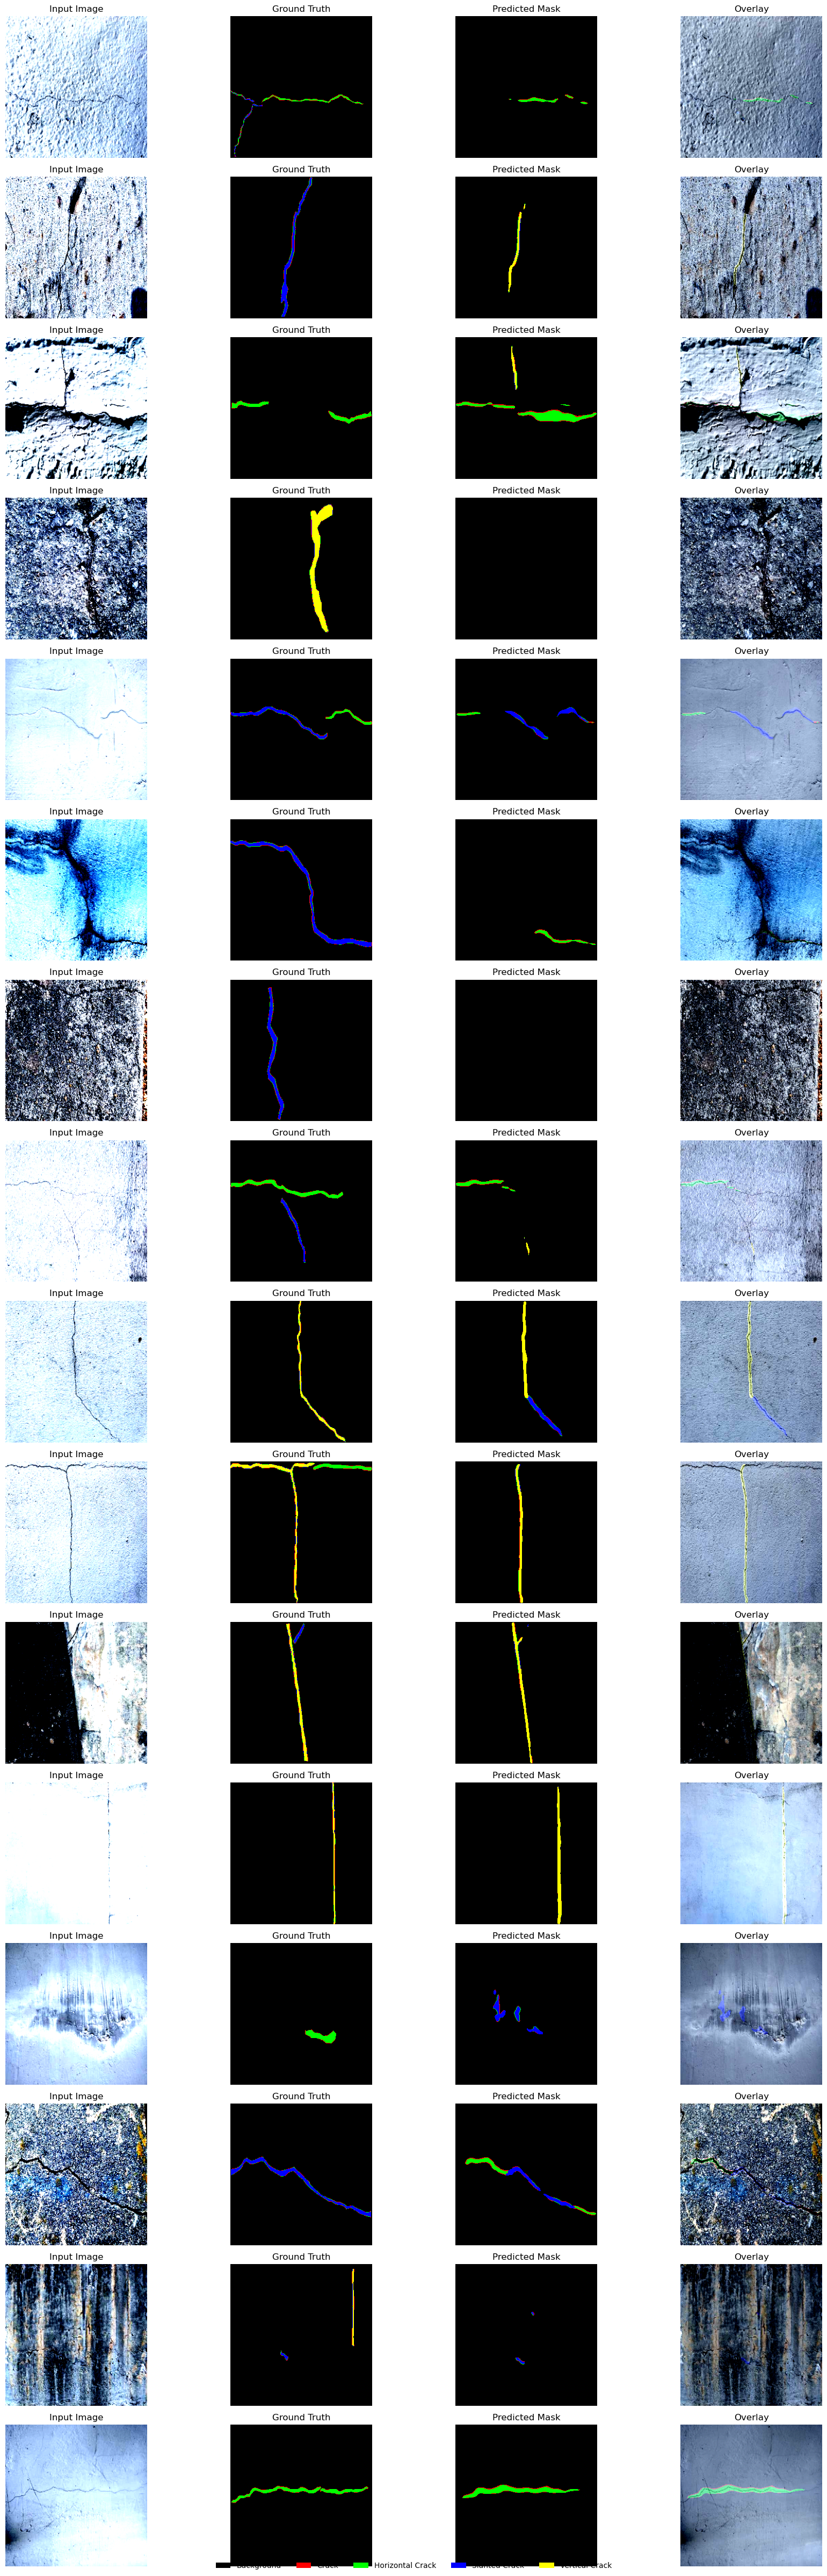

Saved visualization as 'predictions_visualization.png'


In [10]:
class_labels = ["Background", "Crack", "Horizontal Crack", "Slanted Crack", "Vertical Crack"]
class_colors = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]
cmap = ListedColormap(np.array(class_colors) / 255.0)

model.eval()
with torch.no_grad():
    imgs, masks = next(iter(test_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    preds = torch.argmax(preds, dim=1).cpu().numpy()

    fig, axes = plt.subplots(batch_size, 4, figsize=(18, batch_size * 3))
    for i in range(batch_size):
        img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(masks[i].squeeze(0).cpu(), cmap=cmap, vmin=0, vmax=num_classes - 1)
        axes[i, 1].set_title("Ground Truth")

        axes[i, 2].imshow(preds[i], cmap=cmap, vmin=0, vmax=num_classes - 1)
        axes[i, 2].set_title("Predicted Mask")

        mask_rgb = np.zeros_like(img_np)
        for cls in range(num_classes):
            mask_rgb[preds[i] == cls] = class_colors[cls]
        mask_rgb = mask_rgb / 255.0
        overlay = 0.6 * img_np + 0.4 * mask_rgb
        overlay = np.clip(overlay, 0, 1)
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title("Overlay")

    for ax in axes.flat:
        ax.axis("off")
    plt.tight_layout()
    legend_elements = [Patch(facecolor=np.array(c)/255.0, label=label) for c, label in zip(class_colors, class_labels)]
    fig.legend(handles=legend_elements, loc="lower center", ncol=len(class_labels), frameon=False)
    plt.savefig("predictions_visualization.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved visualization as 'predictions_visualization.png'")

# Model Performance on Test Set

In [11]:
model.eval()
test_loss, all_ious = 0, []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks.squeeze(1))
        test_loss += loss.item()
        ious = compute_iou(preds.argmax(1), masks.squeeze(1), num_classes)
        all_ious.append(ious)

test_loss /= len(test_loader)
test_miou = np.nanmean(np.nanmean(all_ious, axis=0))
print(f"Test Loss = {test_loss:.4f}, Test mIoU = {test_miou:.4f}")

Test Loss = 0.5964, Test mIoU = 0.2655
